<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/main/ML/04-Classification/00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification of MNIST digits

In this code, we are tackling the problem of **binary classification** on the MNIST dataset.
The MNIST dataset consists of handwritten digits (0-9), and we aim to classify digits as either 0 or 1, effectively converting the problem into a binary classification task.

This means that you are simplifying the original **multi-class classification problem** of recognizing all digits (0-9) and transforming it into a binary classification problem where you are **only interested in distinguishing between two specific digits**, which are 0 and 1. You want to build a model that can determine whether a given handwritten digit is a '0' or a '1.'

### We will perform the following steps:
1. Load the MNIST dataset from sklearn.
2. Preprocess the data, including converting labels to -1 (digit 0) and +1 (digit 1).
3. Split the data into a training set and a testing set.
4. Train two regression models (Ridge and Lasso) to learn the pixel contributions for classification.
5. Evaluate the models' performance using classification error and confusion matrices.
6. Visualize the learned weights (pixel contributions) for each model.



In [ ]:
import numpy as np

from sklearn.datasets import fetch_openml

The MNIST dataset is a collection of 70,000 grayscale images and have a resolution of 28x28 pixels, resulting in a total of 784 features (pixels) for each sample.

In [ ]:
# Mnist dataset of images 28*28 px = 784 px
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
print(type(mnist))

# Our Data as a pandas DF
X = mnist.data
Y = mnist.target

print(X.shape, type(X))
print(Y.shape, type(Y))

<class 'sklearn.utils._bunch.Bunch'>
(70000, 784) <class 'pandas.core.frame.DataFrame'>
(70000,) <class 'pandas.core.series.Series'>


In [ ]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [ ]:
# Convert X and Y to NumPy arrays so we can us them
X = X.to_numpy()
Y = Y.to_numpy()

print(X.shape, type(X))
print(Y.shape, type(Y))

(70000, 784) <class 'numpy.ndarray'>
(70000,) <class 'numpy.ndarray'>


In [ ]:
# We see that out target is not an integer so we need to convert it
print(type(Y[0]))

Y = np.asarray([eval(i) for i in Y])

print(type(Y[0]))

<class 'str'>
<class 'numpy.int64'>


### Exploratory Data Analysis
Displaying the matrix X is not useful at all, they are only pixels values. Instead what we can do is to reconstruct the images starting from those pixels.

5


(-0.5, 27.5, 27.5, -0.5)

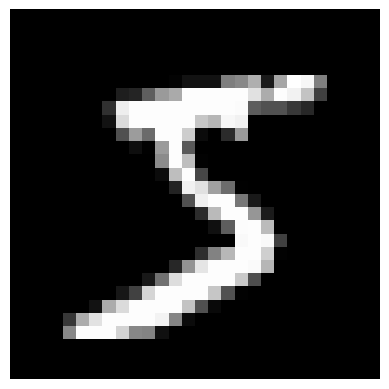

In [ ]:
import matplotlib.pyplot as plt

i = 0
# reshaping and reconstructiong the image
picture = np.reshape(X[i,:], (28,28))

print(Y[i])
fig, ax = plt.subplots()
ax.imshow(picture, cmap=plt.cm.gray)
ax.axis('off')

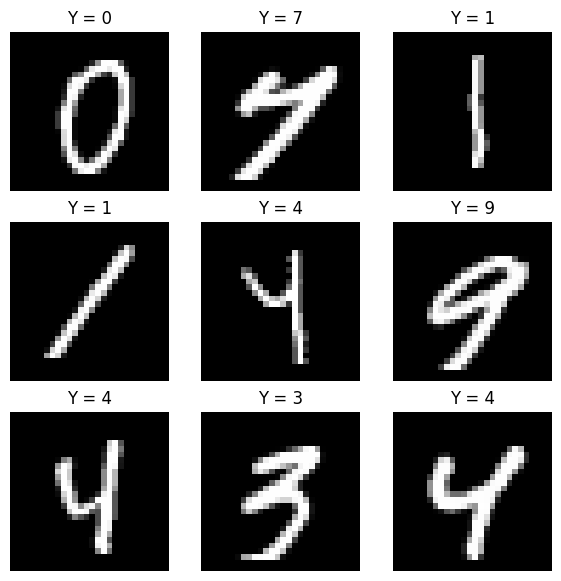

In [ ]:
# creating small multiple
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(7,7))
i = 1000
for ax in axs.reshape(-1):
  ax.set_title("Y = %d" % Y[i])
  picture = np.reshape(X[i,:],(28,28))
  ax.imshow(picture, cmap=plt.cm.gray)
  ax.axis('off')
  i += 1

In [ ]:
"""
print the max and min value of X. We know each pixel of a grayscale image is
formed by pixels of 8 bits with value in 0-255

"""
print(np.max(X))
print(np.min(X))

255.0
0.0


In [ ]:
# Print the number of samples for each class (digits 0-9) -> dataset is balanced

for i in range(0,10):
  tmp = sum(Y == i)
  print(tmp)

6903
7877
6990
7141
6824
6313
6876
7293
6825
6958


Let's first analyse a simpler problem. The matching of digits 0 and 1.
So, we convert the multi-class problem into a binary classification task.
- All samples with the label 'dn' (digit 0) are set to -1 (negative class).
- All samples with the label 'dp' (digit 1) are set to +1 (positive class).
- 'mask' is used to filter the relevant samples.
- 'X' and 'Y' are updated to contain only the selected samples and binary labels.

I have to assign before the digit negative and then the one positive, otherwise
there's the risk that all my values in y becomes -1 (when 0 is first digit)


In [ ]:
dn = 0
dp = 1
mask = (Y == dn) | (Y == dp)
X = X[mask,:]
Y = Y[mask]
Y[Y == dn] = -1 # negative class
Y[Y == dp] = +1 # positive class

In [ ]:
X.shape

(14780, 784)

In [ ]:
Y.shape

(14780,)

Since I have a lot of data and since the complexity is O(n**) what I can do is
subsamplig the data. <br>

I use more data for testing because it's cheaper than learning.

In [ ]:
from random import sample

# Data used for training
n = 100
# Data used for testing
nt = 1000

# Randomly sample n+nt data points from the dataset
mask = np.asarray(sample(range(X.shape[0]),n+nt))

# Split the data into training and testing sets
X = X[mask,:]
Y = Y[mask]

# Create the testing set (Xt and Yt) using samples from n to n+nt
mask = range(n,n+nt)
Xt = X[mask,]
Yt = Y[mask]

# Create the testing set (Xt and Yt) using samples from n to n+nt
mask = range(0,n)
X = X[mask,]
Y = Y[mask]

print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)

(100, 784)
(100,)
(1000, 784)
(1000,)


### Confusion Matrix for Model Evaluation

A confusion matrix is a fundamental tool for evaluating the performance of classification models. It provides a summary of the model's predictions compared to the true class labels.

In the context of binary classification (as in this code), the confusion matrix typically has four values:

- True Positives (TP): The number of samples that were correctly predicted as positive (in our case, digit 1).

- True Negatives (TN): The number of samples that were correctly predicted as negative (in our case, digit 0).

- False Positives (FP): The number of samples that were incorrectly predicted as positive when they were actually negative.

- False Negatives (FN): The number of samples that were incorrectly predicted as negative when they were actually positive.

The confusion matrix is typically presented in the following format:

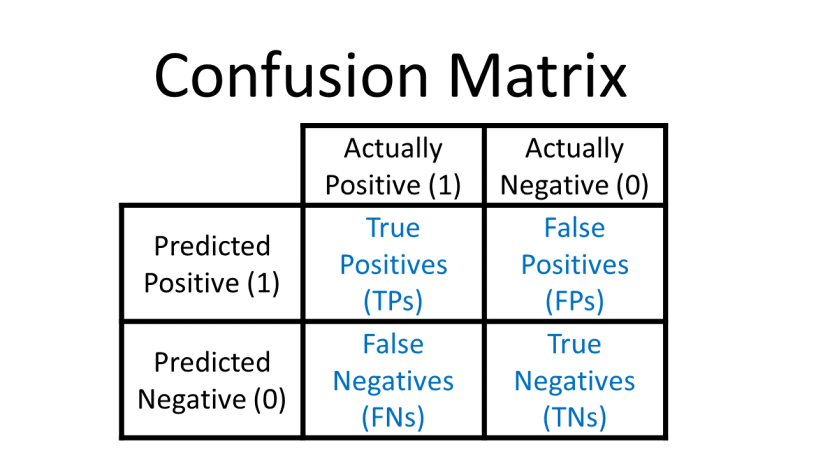

The main diagonal (from top-left to bottom-right) contains the correct predictions (TP and TN).<br>
Off-diagonal elements represent incorrect predictions (FP and FN).
By analyzing the values in the confusion matrix, you can compute various evaluation metrics like accuracy, precision, recall, and F1 score, which provide insights into the model's performance.

In our code, after making predictions (Yp) and comparing them to true labels (Yt), we use the confusion matrix to assess the model's ability to correctly classify digits 0 and 1.

### Ridge Regression

The objective function to minimize here is:

$$||y - Xw||^2_2 + alpha * ||w||^2_2$$

In [ ]:
# KISS (Keep It Simple Stupid) principle encourages simplicity.
from sklearn.linear_model import Ridge
from sklearn.metrics import confusion_matrix

alpha = 1 # Define the regularization strength
M = Ridge(alpha = alpha) # Create a Ridge regression model

# fitting the model
M.fit(X,Y)

# Make predictions and convert them to binary classes (+1 or -1)
Yp = M.predict(Xt)

# Watch out for errors here!! Assign the correct class
Yp[Yp >= 0] = +1
Yp[Yp < 0]  = -1

# Computing the error
err = np.mean(Yp * Yt <= 0)
print(err)
print(confusion_matrix(Yt,Yp))

0.002
[[478   0]
 [  2 520]]


I want to see now the what is the behaviour of my model. <br>
In Ridge regression, the model f(x) is a linear combination of input features x.
$$f(x) = w x + b$$
- If f(x)>0 then the predicted class y is +1
- If f(x)<0 then the predicted class y is -1

So what is the meaning of 'w'?

In the context of image classification:
- Each pixel value in the input image (x) lies in the range [0, 255].
- The learned weight 'w' in the model represents the importance of each pixel.
- *If 'w' is greater than 0, it means that pixel contributes to predicting class +1 (digit 1)*.
- *If 'w' is less than 0, it contributes to predicting class -1 (digit 0)*.

Here, we extract the learned weights 'w' from the Ridge regression model and reshape them to the dimensions of a 28x28 image, representing the importance of each pixel in the decision. <br>
We visualize this weight image using a grayscale colormap to understand which pixels contribute to classifying digits 0 and 1.

- Black color represent negative value, grey the zero and white the positive ones.

The black points are more concentrated on the border, whereas the white ones in the center. So if there are elements in the center is a 1, if there are elements in the border is 0.

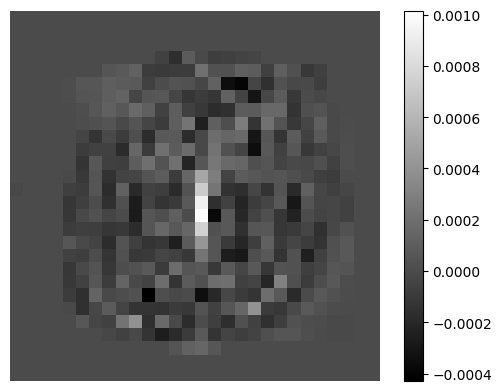

In [38]:
# extract the weights from the Ridge regression model I
w = M.coef_

picture = np.reshape(w,(28,28))
fig, ax = plt.subplots()
plt.imshow(picture, cmap=plt.cm.gray)
ax.axis('off')
plt.colorbar()
# print(w)

### Lasso

Now we use Lasso regression which is a linear regression technique that includes L1 regularization.

$$(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1$$

In [56]:
from sklearn.linear_model import Lasso

alpha = 100 # Define the regularization strength

M = Lasso(alpha = alpha)

# fitting the model
M.fit(X,Y)

# Convert predictions to binary classes (+1 or -1)
Yp = M.predict(Xt)
Yp[Yp >= 0] = +1
Yp[Yp < 0]  = -1

err = np.mean(Yp * Yt <= 0)
print(err)
print(confusion_matrix(Yt,Yp))

0.014
[[472   6]
 [  8 514]]


Very few elements of 'w' are different from 0. Now the model check if there are pixel in the middle then it's classified as one otherwise as zero. <br>

Try to change alpha to see the effect change and to have a more sparse or not solution.

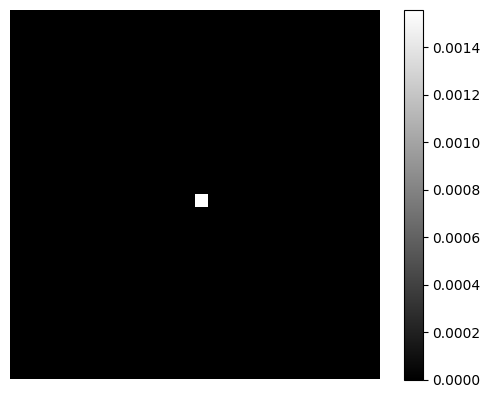

In [57]:
# extract the weights from the Ridge regression model I
w = M.coef_

picture = np.reshape(w,(28,28))
fig, ax = plt.subplots()
plt.imshow(picture, cmap=plt.cm.gray)
ax.axis('off')
plt.colorbar()
# print(w)